## Library Import

In [1]:
# Data Viz. 
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import seaborn as sns
# sns.set_palette(palette='deep')
# sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from sklearn.linear_model import LinearRegression

## Data load and plot

In [2]:
df = pd.read_csv("Advertising_adj.csv")                  
df.head()

,tv,sales
0,230.1,465.26
1,44.5,218.95
2,17.2,195.79
3,151.5,389.47
4,180.8,271.58


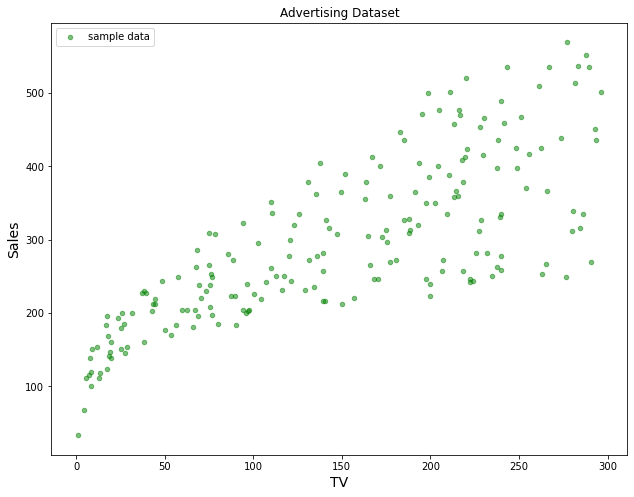

In [3]:
X_data = df.iloc[:,0]
y_data = df.iloc[:,1]
plt.figure(figsize=(4,6))
plt.scatter(X_data, y_data,color='g' ,s = 20, alpha = 0.5, label='sample data')
plt.title('Advertising Dataset'); 
plt.xlabel('TV',fontsize=14); 
plt.ylabel('Sales',fontsize=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

## Baseline linear regression

In [4]:
model = LinearRegression()

model.fit(X_data.values.reshape(-1,1),y_data)

# Now predict on the test set

y_pred = model.predict(X_data.values.reshape(-1,1))

In [5]:
print('The model parameters are, slope (b1) = ' + str(round(model.coef_[0],2)) + ', and the intercept (b0) = ' + str(round(model.intercept_,2)))

The model parameters are, slope (b1) = 1.0, and the intercept (b0) = 148.05


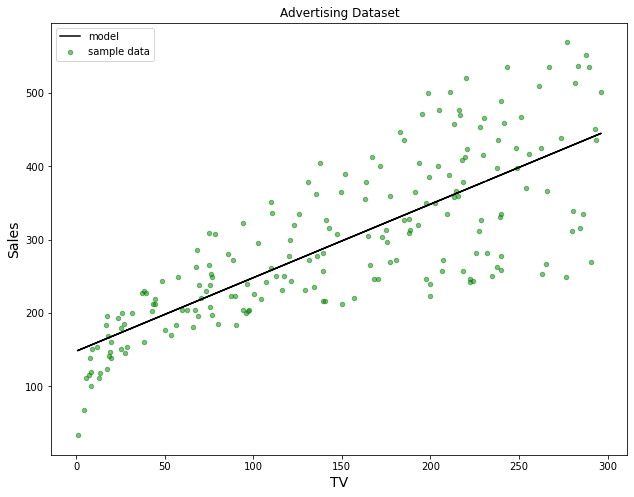

In [6]:
plt.figure(figsize=(4,6))
plt.scatter(X_data, y_data, color='green', s = 20, alpha = 0.5, label='sample data')
plt.plot(X_data, y_pred, label='model', color = 'black')
plt.plot
plt.title('Advertising Dataset'); 
plt.xlabel('TV',fontsize=14); 
plt.ylabel('Sales',fontsize=14)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

## TFP method

### Convert data 

In [7]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [8]:
# Set seed.
tf.random.set_seed(42)
# Set tensor numeric type.
dtype = 'float32'

In [9]:
x = tf.convert_to_tensor(X_data, dtype=dtype)
x = tf.reshape(x,(-1,1))
y = tf.convert_to_tensor(y_data, dtype=dtype)
y = tf.reshape(y, (-1, 1))

## Make Bayesian random variables 

In [10]:
model = tfd.JointDistributionNamedAutoBatched(dict(

    sigma=tfd.HalfNormal(scale=[tf.cast(1.0, dtype)]),

    alpha=tfd.Normal(
        loc=[tf.cast(100.0, dtype)], 
        scale=[tf.cast(50.0, dtype)]
    ),

    beta=tfd.Normal(
        loc=[[tf.cast(0.0, dtype)]], 
        scale=[[tf.cast(10.0, dtype)]]
    ),

    y=lambda beta, alpha, sigma: 
        tfd.Normal(
            loc=tf.linalg.matmul(x, beta) + alpha, 
            scale=sigma
        ) 
))

### Get probabilities

In [11]:
def target_log_prob_fn(beta=None, alpha=None, sigma=None):
    return model.log_prob(beta=beta, alpha=alpha, sigma=sigma, y=y)

In [12]:
# Size of each chain.
num_results = int(1e4)
# Burn-in steps.
num_burnin_steps = int(3e3)

# Hamiltonian Monte Carlo transition kernel. 
# In TFP a TransitionKernel returns a new state given some old state.
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob_fn,
  step_size=1.0,
  num_leapfrog_steps=3
  
)

# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)

# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in). 
  # Implements MCMC via repeated TransitionKernel steps.
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[
          tf.convert_to_tensor([[1.0]], dtype=dtype),
          tf.convert_to_tensor([100.0], dtype=dtype), 
          tf.convert_to_tensor([1.0], dtype=dtype)
      ],
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )
  return samples, is_accepted

In [13]:
this, that = run_chain()

In [14]:
num_chains = 5
chains = []
for i in range(num_chains):
    this, that = run_chain()
    chains.append([i[that] for i in this])

In [15]:
# # Set number of chains. 
# num_chains = 3
# # Run sampling. 
# chains = [run_chain() for i in range(num_chains)]

## Workflow

- You get a list of chain runs [$c_1$,$c_2$,$c_3$]
- Each chain run $c_i$ is a list of distributions for the parameters. In our case, $c_i$ = [$\beta,\alpha,\sigma$] for that run
- First step we collect all the parameters form *different* runs together. We do this by using `zip(*chains)` (cleaner: `list(map(list,zip(*chains)`)
- Now this list (let's call this `chains_t`) needs to be made *run agnostic*
- To do this, for each entry in chains_t, we will need to make it into a single list, and to do this, for a parameter sample we use `tf.concat(sample,axis=0)`
- We do this for each considered parameter as `[tf.squeeze(tf.concat(samples,axis=0)) for samples in chains_t]`

In [16]:
# See comments above
chains_t = list(map(list, zip(*chains)))

# See comments above
chains_samples = [tf.squeeze(tf.concat(samples, axis=0)) for samples in chains_t]

In [17]:
# Here we make individual dataframes and just stick them together column wise
chains_df = pd.concat(
    objs=[pd.DataFrame(samples.numpy()) for samples in chains_samples], 
    axis=1
)
params = ['beta_1', 'beta_0', 'sigma']
chains_df.columns = params
chains_df.head()

,beta_1,beta_0,sigma
0,1.223157,107.851036,30.403650
1,1.220178,107.789993,30.323538
2,1.226574,107.712769,30.264297
3,1.211441,107.709755,30.263187
4,1.198196,107.851707,30.285734


In [18]:
# Using the dataframe.assign function to get the len of data frame (will give the total run)
# Then we use this along with num_results to get the chain_sample_id (will give the max run for each chain)
# Then we use the sample id again to get the iteration (will give the chain number)
# Then we convert it to a string for ease of view
chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % num_results,
        chain_id=lambda x: (x['sample_id'] / num_results).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str)) \
    

chains_df.head()

,beta_1,beta_0,sigma,sample_id,chain_sample_id,chain_id
0,1.223157,107.851036,30.403650,0,0,c_1
1,1.220178,107.789993,30.323538,1,1,c_1
2,1.226574,107.712769,30.264297,2,2,c_1
3,1.211441,107.709755,30.263187,3,3,c_1
4,1.198196,107.851707,30.285734,4,4,c_1


# Plotting

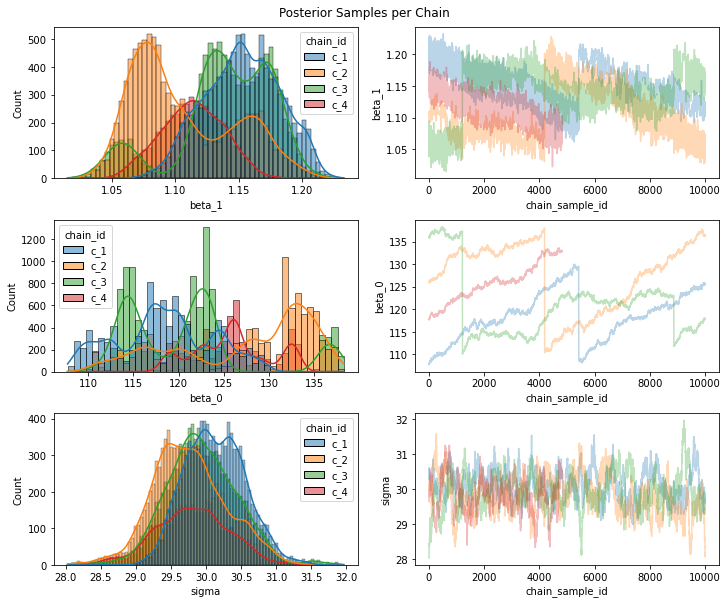

In [19]:
# Define the figure
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)


for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0])
    # Here we give the full dataframe as data, the 'hue' tells what to color, and axes - All clear
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.3, legend=False, ax=axes[i][1])
    # Here the x axis is the chain run, y-axis is the value, data is the full dataframe, color depends on chain

fig.suptitle('Posterior Samples per Chain', y=1.03);

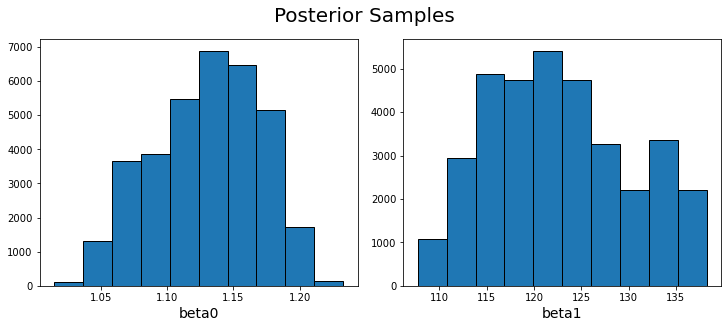

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=True)

betaname = ['beta0','beta1']

for i, param in enumerate(params[:2]):
    axes[i].hist(x=param,data=chains_df,edgecolor='k')
    axes[i].set_xlabel(betaname[i],fontsize=14)

fig.suptitle('Posterior Samples', y=1.10,fontsize=20);